# Develop a code to plot network and interconnection using geospatial data

In [1]:
pip install pandas geopandas matplotlib networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('Air_Quality_Index.csv')
geo_data = gpd.read_file('countries.geojson')


In [5]:
country_aqi = data.groupby('Country')['AQI Value'].mean().reset_index()

In [7]:
geo_aqi = geo_data.merge(country_aqi, left_on='ADMIN', right_on='Country', how='inner')

In [9]:
geo_aqi['normalized_aqi'] = (geo_aqi['AQI Value'] - geo_aqi['AQI Value'].min()) / (geo_aqi['AQI Value'].max() - geo_aqi['AQI Value'].min())

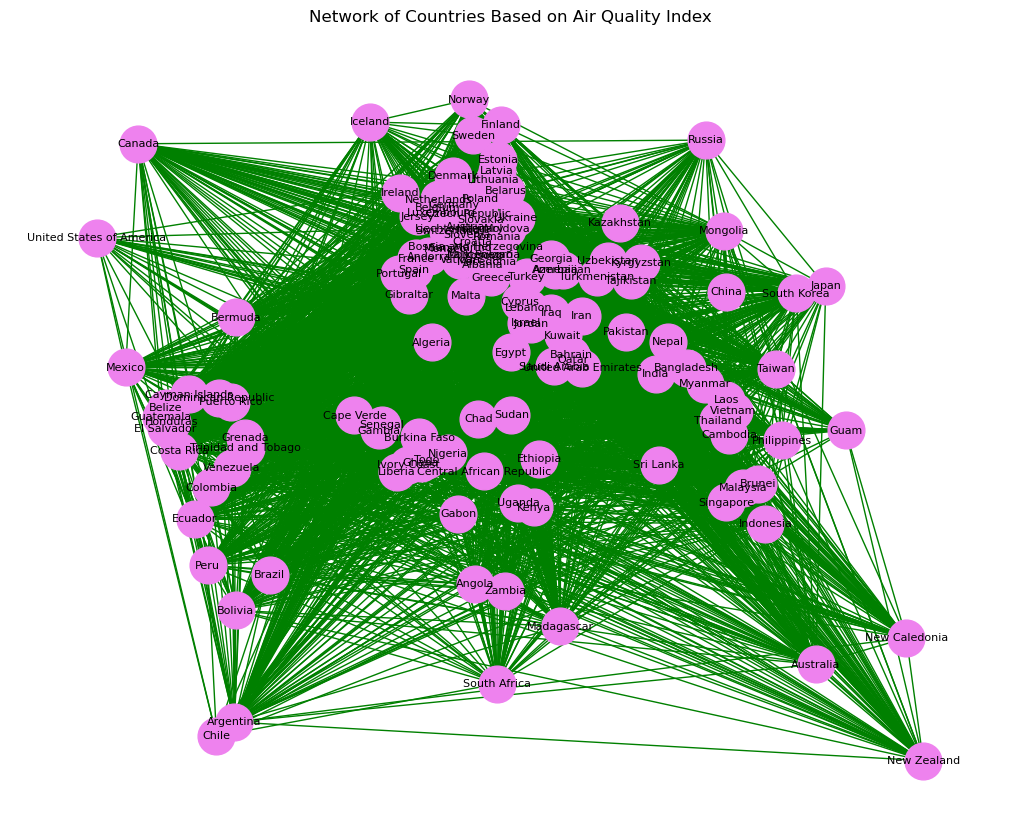

In [13]:
G = nx.Graph()

# Add nodes with geospatial positions
for _, row in geo_aqi.iterrows():
    G.add_node(row['Country'], pos=(row['geometry'].centroid.x, row['geometry'].centroid.y), AQI=row['AQI Value'])

# Add edges based on AQI similarity (e.g., if normalized AQI difference < threshold)
threshold = 0.2
countries = geo_aqi['Country'].tolist()
for i, country1 in enumerate(countries):
    for j, country2 in enumerate(countries):
        if i < j:  # Avoid duplicate edges
            aqi1 = geo_aqi[geo_aqi['Country'] == country1]['normalized_aqi'].values[0]
            aqi2 = geo_aqi[geo_aqi['Country'] == country2]['normalized_aqi'].values[0]
            if abs(aqi1 - aqi2) < threshold:
                G.add_edge(country1, country2, weight=1 - abs(aqi1 - aqi2))

# Get positions for plotting
positions = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(
    G, 
    pos=positions, 
    with_labels=True, 
    node_color='violet', 
    node_size=700, 
    font_size=8, 
    edge_color='green'
)
plt.title("Network of Countries Based on Air Quality Index")
plt.show()